In [1]:
import numpy as np
import pandas as pd
import lostruct as ls
from skbio.stats.ordination import pcoa
import plotly.express as px
import plotly.graph_objects as go
import phate
from collections import Counter
import phate
import umap
import statistics as stats
#import hdbscan
import phate
from sklearn.decomposition import PCA

In [2]:
vcf_file = "trained_filtered.bcf"
landmarks = ls.get_landmarks(vcf_file)
samples = ls.get_samples(vcf_file)

In [3]:
results = list()
snp_positions = list()
snps = list()

for landmark in landmarks:
    windows, positions = ls.parse_vcf(vcf_file, landmark, 450)
    for i, window in enumerate(windows):
        snps.append(window)
        results.append(ls.eigen_windows(window, 10, 1))
        snp_positions.append([landmark, positions[i]])

In [4]:
len(snp_positions)

3062

In [5]:
#results

In [6]:
# Parse VCF to get windows and positions of each SNP within each window
#windows, positions = ls.parse_vcf(vcf_file, "S3", 250)
# ls.Window.SNP specifies window sizes are by SNP count. ls.Window.BP specifies windows are in base pair lengths.

# *** ls.Window.BP is not yet implemented, however. ***
# Please see: https://github.com/jguhlin/lostruct-py/issues/8

# Accumulate output of eigen_windows
#result = list()
#for x in windows:
#    result.append(ls.eigen_windows(x, 2, 1))

In [7]:
# Convert to numpy array
result = np.vstack(results)

/home/josephguhlin/miniconda3/envs/lostruct/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
# Get PCA distances comparison matrix
# pc_dists = ls.get_pc_dists(result)

In [9]:
# An additional mode, fastmath, is available. Trading some accuracy for a slight speed boost (~8%)
pc_dists = ls.get_pc_dists(result, fastmath=True)

In [10]:
#pc_dists = np.load("pc_dists.npy")
#np.save("localpca_all_results.npy", result)
#np.save("localpca_all.npy", pc_dists)
#np.save("localpca_all_positions.npy", snp_positions)

/home/josephguhlin/miniconda3/envs/lostruct/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [3]:
result = np.load("localpca_all_results.npy", allow_pickle=True)
pc_dists = np.load("localpca_all.npy", allow_pickle=True)
snp_positions = np.load("localpca_all_positions.npy", allow_pickle=True)
results = result

In [4]:
pc_dists.shape

(3062, 3062)

In [5]:
pc_dists[0][5]

0.6949571726418234

In [6]:
# Get PCoA value of pc_dists matrix (this is equivalent to R's MDS)
# PLEASE NOTE: See section below: Working with Large Datasets
# For recommended ways to run pcoa

mds = pcoa(pc_dists, inplace=True, method="fsvd", number_of_dimensions=6)
#mds = pcoa(pc_dists[:2500, :2500], inplace=True, method="fsvd", number_of_dimensions=6)

In [7]:
mean = np.mean(mds.samples["PC1"])
sd = np.std(mds.samples["PC1"])

previous_pos = 0
highlights = list()
current_chr = "S1"
current_start = 0
current_end = 0

for pos in np.where(np.abs(mds.samples["PC1"]) >= mean + 2 * sd)[0]:
    if pos == previous_pos + 1:
        current_end = snp_positions[pos][1][-1]
    else:
        #print("Previous: {} cur: {}".format(previous_pos, pos))

        if previous_pos != 0:
            highlights.append((current_chr, current_start, current_end))
        
        current_chr   = snp_positions[pos][0]
        current_start = snp_positions[pos][1][0]
        current_end   = snp_positions[pos][1][-1]
        previous_pos = pos

with open("mds1.highlight", 'w') as writer:
    for x in highlights:
        writer.write("\t".join(map(str, x)))
        writer.write("\n")

In [8]:
mean = np.mean(mds.samples["PC2"])
sd = np.std(mds.samples["PC2"])

previous_pos = 0
highlights = list()
current_chr = "S1"
current_start = 0
current_end = 0

for pos in np.where(np.abs(mds.samples["PC2"]) >= mean + 2 * sd)[0]:
    if pos == previous_pos + 1:
        current_end = snp_positions[pos][1][-1]
    else:
        #print("Previous: {} cur: {}".format(previous_pos, pos))

        if previous_pos != 0:
            highlights.append((current_chr, current_start, current_end))
        
        current_chr   = snp_positions[pos][0]
        current_start = snp_positions[pos][1][0]
        current_end   = snp_positions[pos][1][-1]
        previous_pos = pos

with open("mds2.highlight", 'w') as writer:
    for x in highlights:
        writer.write("\t".join(map(str, x)))
        writer.write("\n")

In [9]:
from itertools import cycle

In [10]:
kakapo_colors = ["#7D9D33", "#CED38C", "#DCC949", "#BCA888", "#CD8862", "#775B24"]
chrs = [i[0] for i in snp_positions]
colorfn = cycle(["#7D9D33", "#DCC949", "#BCA888", "#CD8862", "#775B24"])
colors = [next(colorfn) for _ in chrs]

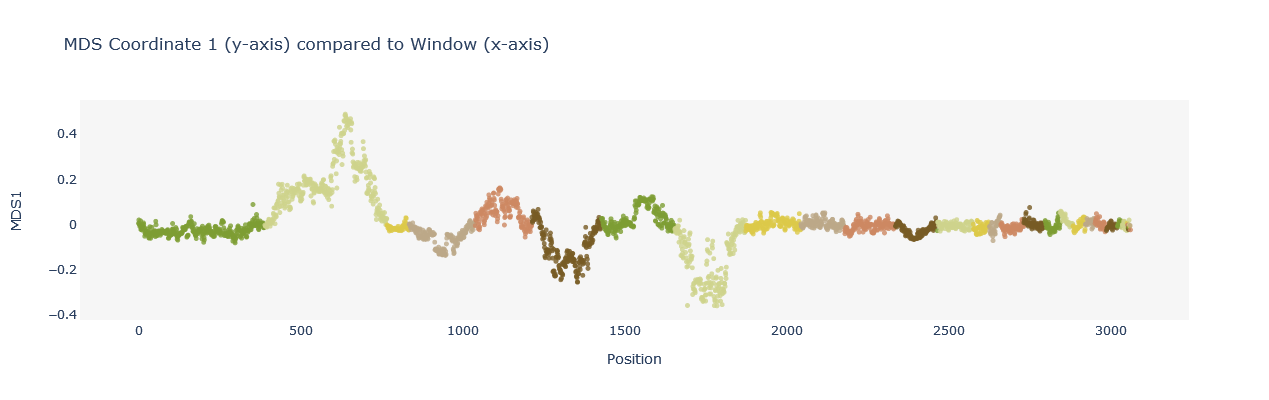

In [17]:
fig = px.scatter(y=mds.samples["PC1"], 
                 title="MDS Coordinate 1 (y-axis) compared to Window (x-axis)", 
                 color=chrs, 
                 labels=chrs,
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=400
                )

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="Position"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="MDS1"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mds_coord1.svg")
fig.write_image("mds_coord1.png")
fig

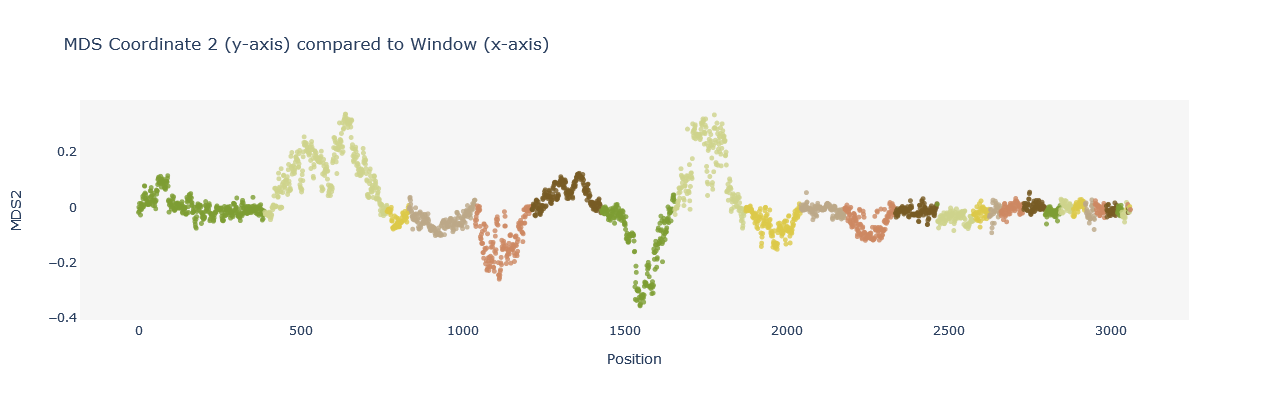

In [18]:
#px.scatter(y=mds.samples["PC2"], title="MDS Coordinate 2 (y-axis) compared to Window (x-axis)")
fig = px.scatter(y=mds.samples["PC2"], 
                 title="MDS Coordinate 2 (y-axis) compared to Window (x-axis)", 
                 color=chrs, 
                 labels=chrs,
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=400
                )

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="Position"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="MDS2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mds_coord2.svg")
fig.write_image("mds_coord2.png")
fig

In [21]:
[np.mean(mds.samples["PC1"]), np.std(mds.samples["PC1"])]

[9.28207362194775e-16, 0.10287172503716474]

In [22]:
twosd = np.mean(mds.samples["PC1"]) + 5 * np.std(mds.samples["PC1"])
mds.samples["PC1"][np.abs(mds.samples["PC1"]) >= twosd]


Series([], Name: PC1, dtype: float64)

In [28]:
result[620][3].shape

(10, 169)

In [38]:
# PC1 is really PC0...
pc = 1

output = list()
pc = pc - 1

for i, name in enumerate(samples):
    output.append(result[620][3][pc, i])
    # print(result[620][3][pc, i])

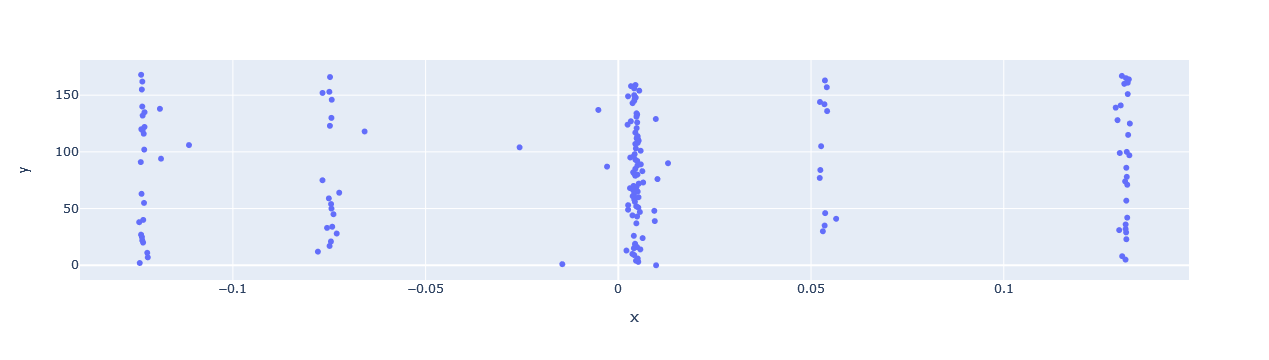

In [37]:
px.scatter(x=output)

In [ ]:
#for j in snp_positions:
#    print(j[1])

In [ ]:
snp_positions[1][1][125]

In [ ]:
mds.samples["PC1"]

In [ ]:
with open("pc2.scatter", 'w') as writer:
    for i,_ in enumerate(snp_positions):
        output_line = list()
        output_line.append(snp_positions[i][0])
        output_line.append(snp_positions[i][1][0])
        output_line.append(snp_positions[i][1][-1])
        output_line.append(mds.samples["PC2"][i])
        writer.write("\t".join(map(str, output_line)))
        writer.write("\n")

In [ ]:
result.shape

In [ ]:
[mds.samples["PC2"].min(), mds.samples["PC2"].max()]

In [ ]:
[np.mean(mds.samples["PC1"]), np.std(mds.samples["PC1"])]

In [ ]:
np.argmin(np.abs(mds.samples["PC1"]) + np.abs(mds.samples["PC2"]))

# Getting the colors rights

In [ ]:
kakapo_colors = ["#7D9D33", "#CED38C", "#DCC949", "#BCA888", "#CD8862", "#775B24"]

# Local PCA Windows, zoom in

In [ ]:
colors = [x == "Richard_Henry" for x in samples]

In [ ]:
results[80][3].T.shape

In [ ]:
fig = px.scatter(x=results[875][3][0], 
                 y=results[875][3][1], 
                 color=colors, 
                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("window_875.svg")
fig


In [ ]:
fig = px.scatter(x=results[3173][3][0], 
                 y=results[3173][3][1], 
                 color=colors, 
                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("window_3173.svg")
fig


In [ ]:
results[80][3][1].shape

# Global Mean PCA From Plink

In [136]:
ev = pd.read_csv("pop.eigenval", header=None)
ev = ev.to_numpy().flatten()
ev

array([35.5082 ,  8.52597,  6.97002,  5.66725,  5.42365,  4.59729,
        4.42352,  3.75971,  3.35021,  3.32723])

In [137]:
[ev[0]/np.sum(ev), ev[1]/np.sum(ev)]

[0.43540002489177293, 0.10454507832631642]

In [133]:
plink2 = pd.read_csv("pop.eigenvec", sep="\t")
plink2.head()

,#IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,Adelaide,0.121252,-0.055379,0.324582,0.002824,-0.041028,0.108892,0.194435,0.021716,0.007997,0.043189
1,Al,-0.018447,0.055889,-0.008810,-0.041822,-0.054118,0.049977,-0.032185,0.038774,-0.032702,0.012772
2,Alice,-0.017812,0.044799,-0.013801,0.005995,0.038771,0.099706,-0.064016,-0.012581,-0.092137,0.012526
3,Aparima,-0.017613,0.043667,-0.002607,-0.015595,-0.162413,-0.054546,-0.006339,0.059537,-0.026003,0.065747
4,Arab,-0.016645,-0.001659,-0.029845,-0.059930,0.006734,0.124717,-0.060965,-0.038350,-0.061580,-0.016548


In [134]:
rh

,#IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
23,Flossie,-0.038556,0.216815,0.115016,-0.0751,-0.007999,-0.127383,-0.251347,0.108646,0.179789,-0.057291


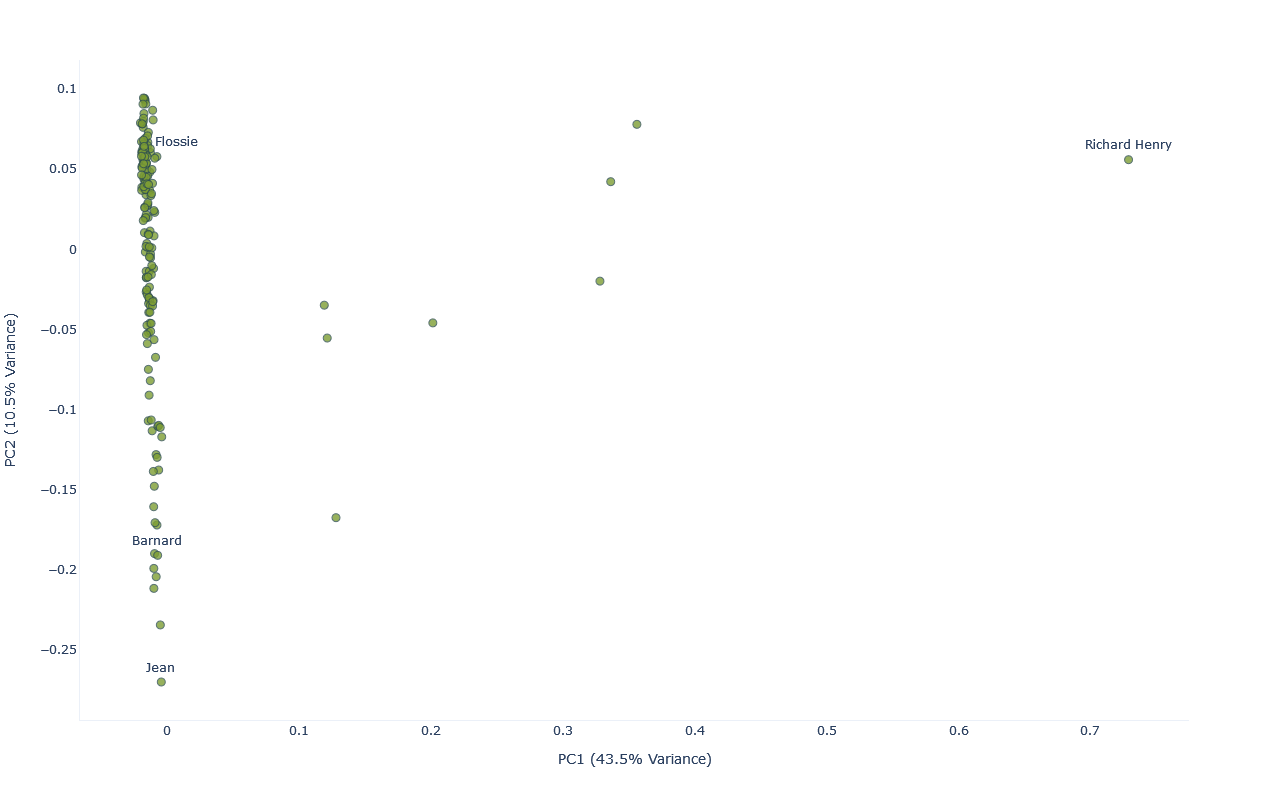

In [140]:
fig = px.scatter(x=plink2['PC1'], 
                 y=plink2['PC2'], 
                 #color=colors, 
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=800,
                 #text=plink2["#IID"],
                 template="plotly_white")

rh = plink2[plink2['#IID'] == "Richard_Henry"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Richard Henry", showarrow=False, yshift=15)
rh = plink2[plink2['#IID'] == "Barnard"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Barnard", showarrow=False, yshift=15)
rh = plink2[plink2['#IID'] == "Jean"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Jean", showarrow=False, yshift=15)
rh = plink2[plink2['#IID'] == "Flossie"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Flossie", showarrow=False, yshift=15, xshift=20)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1 (43.5% Variance)"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2 (10.5% Variance)"))
#fig.update_layout(paper_bgcolor="white")
#fig.update_layout(plot_bgcolor="#f6f6f6")


fig.write_image("global_pca_all.svg")
fig.write_image("global_pca_all.png")

fig

## Global Mean PCA Plink2 Founders Only

In [128]:
ev = pd.read_csv("founders35.eigenval", header=None)
ev = ev.to_numpy().flatten()
ev

array([8.74387, 2.9305 , 2.02758, 1.77193, 1.48016, 1.37613, 1.28062,
       1.18369, 1.08452, 1.0069 ])

In [129]:
[ev[0]/np.sum(ev), ev[1]/np.sum(ev)]

[0.3820636286971454, 0.12804827426494042]

In [130]:
plink2 = pd.read_csv("founders35.eigenvec", sep="\t")
plink2.head()

,#IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,Sandra,-0.018178,-0.092153,-0.075674,-0.326345,-0.264481,0.240143,0.010426,0.061446,-0.156534,0.031573
1,Stumpy,-0.039396,0.132720,0.068026,-0.193007,0.165206,-0.310344,0.340543,0.173425,-0.144747,-0.069051
2,Smoko,-0.029399,-0.025573,-0.049420,-0.125791,0.213817,-0.158067,0.163720,-0.311369,0.044373,-0.036173
3,Ruth,-0.020484,-0.036181,-0.048114,0.364888,-0.320460,-0.201055,-0.070536,-0.266321,0.049395,-0.235579
4,Fuchsia,-0.022748,-0.155519,-0.197860,0.054053,0.069049,-0.142409,-0.245921,-0.081713,-0.174111,-0.011878


In [131]:
float(rh['PC1'])

-0.0512304

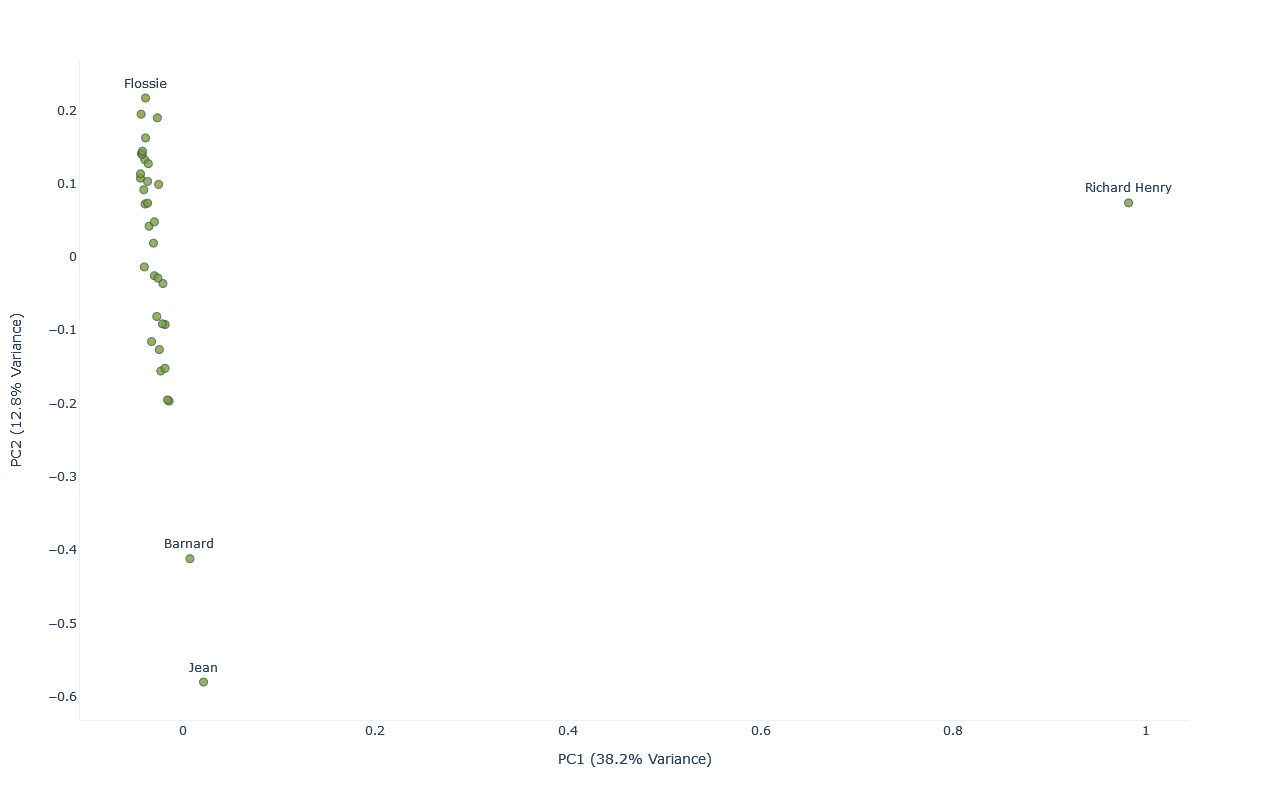

In [132]:
fig = px.scatter(x=plink2['PC1'], 
                 y=plink2['PC2'], 
                 #color=colors, 
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=800,
                 #text=plink2["#IID"],
                 template="plotly_white")

rh = plink2[plink2['#IID'] == "Richard_Henry"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Richard Henry", showarrow=False, yshift=15)

rh = plink2[plink2['#IID'] == "Barnard"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Barnard", showarrow=False, yshift=15)

rh = plink2[plink2['#IID'] == "Jean"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Jean", showarrow=False, yshift=15)

rh = plink2[plink2['#IID'] == "Flossie"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Flossie", showarrow=False, yshift=15)


fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1 (38.2% Variance)"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2 (12.8% Variance)"))
fig.update_traces(textposition='bottom center')
#fig.update_layout(paper_bgcolor="white")
#fig.update_layout(plot_bgcolor="#f6f6f6")

#fig.add_annotation(x=0.578114, y=-0.024875, text="Richard Henry", showarrow=False, yshift=15) #, yshift=0.001)

fig.write_image("global_pca_founders35.svg")
fig.write_image("global_pca_founders35.png")



fig

## Global Mean PCA

In [23]:
snps_new = list()
for j in snps:
    snps_new.append(j.todense())

snps = np.asarray(snps_new)


In [24]:
snps.shape

(3062, 450, 169)

In [28]:
snps = np.reshape(snps, (3062*450, 169))
snps.shape

(1377900, 169)

In [29]:
snps_nomissing = snps[~np.isnan(snps).any(axis=1), :]
snps_nomissing.shape

(642172, 169)

In [30]:
from sklearn.preprocessing import StandardScaler

pca = PCA(2)
pcs = pca.fit_transform(StandardScaler().fit_transform(snps_nomissing.T))

In [31]:
pcs.shape

(169, 2)

In [32]:
pcs = StandardScaler().fit_transform(pcs)

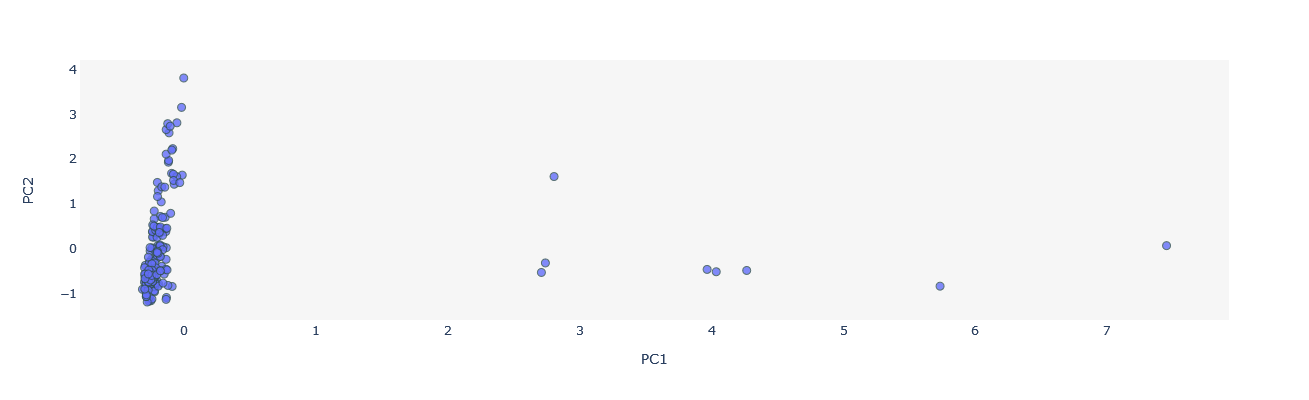

In [35]:
# Plot for Supplemental

fig = px.scatter(x=pcs[:, 0], y=pcs[:, 1], 
#                 color=colors,
#                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mean_pca.svg")
fig

In [ ]:
# Larger founder relatedness plot

fig = px.scatter(x=pcs[:, 0], y=pcs[:, 1], color=samples,
                 labels=samples, text=samples,
                 color_discrete_sequence=kakapo_colors,
                 width=800, height=800)

fig.update_traces(marker=dict(size=8, opacity=0.95, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mean_pca.svg")
fig.update_traces(textposition='top center')
fig.write_image("founders_relatedness_large.svg")

fig

In [ ]:
pca.explained_variance_ratio_

# From previous calc

In [14]:
pcs = list()
for result in results:
    print(result[3].T.shape)
    break
    pcs.append(result[3].T)

    #for x in result[3].T:
    #    print(x.shape)
    #    pcs.append(x)
    #    print(x)
    #    break

(169, 10)


In [15]:
np.asarray(pcs).shape

(0,)

In [16]:
pcs = np.mean(pcs, axis=1)
pcs.shape

AxisError: axis 1 is out of bounds for array of dimension 1

In [17]:
px.scatter(x=pcs[:, 0], y=pcs[:, 1], color=samples)

TypeError: list indices must be integers or slices, not tuple

In [18]:
plink2 = pd.read_csv("plink2.eigenvec", sep="\t")
plink2

,#IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,Adelaide,0.206707,-0.008444,-0.023067,-0.010730,-0.074267,0.079921,-0.239378,0.164124,-0.184797,-0.036443
1,Al,-0.024572,-0.054252,0.035171,-0.055832,0.057071,-0.028582,-0.044667,0.004567,-0.007393,0.022168
2,Alice,-0.023861,-0.042174,-0.000864,0.040135,0.123360,0.015736,-0.065396,-0.050525,0.065055,-0.023805
3,Aparima,-0.022589,-0.040333,0.000232,-0.162433,-0.046453,-0.068463,-0.050347,-0.046390,-0.061298,0.004947
4,Arab,-0.021014,0.006959,0.063184,-0.001303,0.142783,0.048478,-0.041853,-0.016935,0.016053,0.035803
...,...,...,...,...,...,...,...,...,...,...,...
164,Whiskas,-0.012283,0.042587,0.162317,0.105080,0.006788,-0.111362,-0.071470,-0.125953,-0.222906,0.026014
165,Wiremu,-0.005314,-0.029176,0.129990,0.107423,-0.044951,-0.039544,-0.068304,0.050040,-0.037652,-0.056906
166,Wolf,-0.014788,-0.008322,-0.148188,0.087755,-0.010043,-0.061555,0.012235,0.138602,-0.026028,0.039541
167,Yasmine,-0.010621,-0.036505,0.040163,0.031329,-0.086074,0.108406,0.012493,0.029112,0.079002,-0.150378


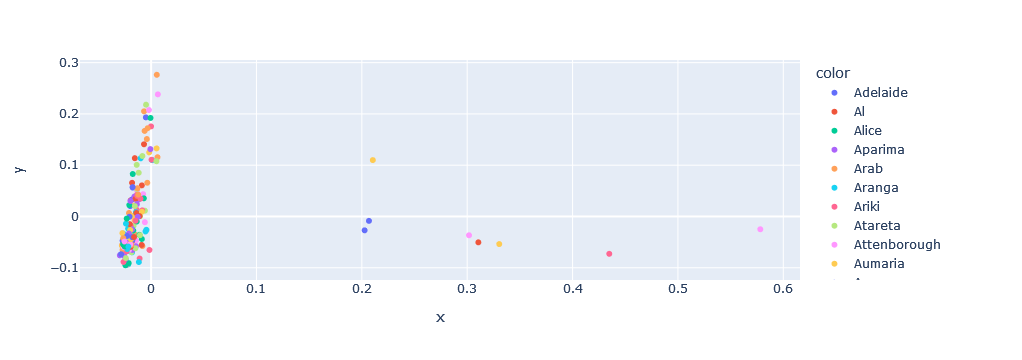

In [19]:
px.scatter(x=plink2["PC1"], y=plink2["PC2"], color=plink2["#IID"])

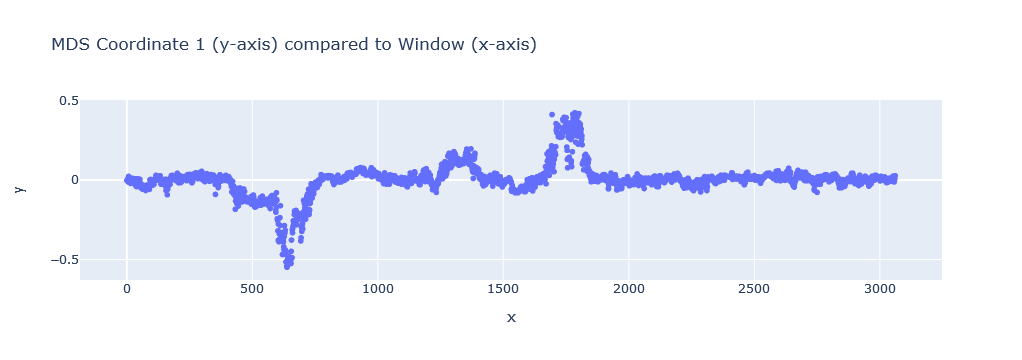

In [20]:
px.scatter(y=mds.samples["PC1"], title="MDS Coordinate 1 (y-axis) compared to Window (x-axis)")

In [21]:
def get_furthest_individuals(results):
    furthest = list()
    for n,result in enumerate(results):
        d = dict()
        vals = list()
        for i,x in enumerate(result[3].T):
            centroid = np.mean(result[0][3].T, axis=0)
            dist = np.linalg.norm(x-centroid)
            d[dist] = i
            vals.append(dist)
        vals = sorted(vals)
        vals.reverse()
        furthest.append((n, samples[d[vals[0]]]))
        #tops = [samples[d[x]] for x in vals[0]]
        #tops.sort()
        
        #furthest.append(tuple(tops))
    return furthest

get_furthest_individuals(result)

AxisError: axis 0 is out of bounds for array of dimension 0

In [22]:
bychr_pop = list()

for n in range(len(result)):
    toplot = result[n][3]
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(toplot.T)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=0.5)
    clusterer.fit(embedding)
    
    d = dict()
    
    for i in clusterer.labels_:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    
    bychr_pop.append(d)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.0435775   0.04429834 -0.15121442  0.24127029 -0.1642556   0.01368041
 -0.05530565 -0.16891806  0.01936535  0.02268235  0.20862609 -0.16864708
  0.04367054  0.11823958 -0.14245844  0.03972945 -0.1671434  -0.04810828
 -0.140923   -0.04543667  0.05120884  0.01592616  0.02907806  0.02426211
 -0.03962263  0.02102286  0.04103756 -0.07720812  0.02979948  0.02393732
 -0.05057492  0.02172872  0.02868976  0.00623191  0.21544941  0.2142002
  0.04731563 -0.14447588  0.01981371 -0.2029837  -0.16866165  0.04739846
 -0.16580386  0.02965682  0.0445995  -0.16808596  0.01264805 -0.14570773
 -0.02609893 -0.04435308 -0.02958169  0.027031    0.11628898  0.01910404
  0.04597811 -0.1678249  -0.16888864  0.20670468  0.02283035 -0.05212195
 -0.17021804  0.02652366  0.02277315  0.03203527 -0.12285754  0.02328312
  0.02500764  0.04844446  0.02996952  0.01800295  0.02906272 -0.14653084
  0.02551884  0.02004867  0.04406194  0.02268235 -0.20943879  0.04822922
  0.21188332  0.03226137  0.02135143  0.05283117 -0.16726346 -0.16828541
  0.02468238  0.02962364  0.02906272  0.04580785  0.11624777  0.11809324
 -0.0240854  -0.02788644 -0.16357507  0.21806039  0.21958937 -0.07343484
  0.02502567  0.02346099 -0.0740985  -0.12516752  0.15425931 -0.1678443
  0.21489011  0.0470188  -0.02866575  0.20448782 -0.05274573  0.02241735
  0.01473211 -0.05030985  0.02311021  0.01773202  0.02419186  0.15725236
  0.21471852 -0.14330165 -0.16192679  0.01707879 -0.21823141 -0.16809405
  0.04408641 -0.02984326 -0.17014016 -0.05061841 -0.05101052  0.03670846
  0.11886207  0.02825255 -0.02865109 -0.03540883  0.2163243   0.1364847
  0.02347778  0.02565391  0.02886542  0.02194378 -0.0487594  -0.02698793
  0.02374805  0.04223865  0.2119792   0.04429834 -0.02873436  0.02374545
 -0.14622831  0.04363269 -0.02680503  0.02506823  0.21047623 -0.07667342
 -0.16917105  0.02200617  0.02419186 -0.05031621  0.2172416  -0.16785958
  0.04957011  0.04525265  0.04802736 -0.16622213  0.02394163  0.15613793
  0.02497213 -0.1678249   0.13911042  0.21411633 -0.17019592 -0.1465964
  0.02224989].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
groups = dict()
plot_data = list()

z = list(bychr_pop[0].keys())
z.sort()
z

for n in bychr_pop:
    for i in range(-1, 7):
        if i not in groups:
            groups[i] = list()
        if i not in n:
            groups[i].append(0)
        else:
            groups[i].append(n[i])
        #plot_data.append(bychr_pop[0][i])


In [ ]:
groups.keys()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[-1]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[0]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[1]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[2]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[3]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[4]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[5]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[6]))

fig.update_layout(barmode='stack')


In [ ]:
px.scatter(x=embedding[:,0], y=embedding[:,1], color=samples)

In [ ]:
[positions[pc_loc][0], positions[pc_loc][-1]]

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=0.5)
clusterer.fit(embedding)

In [ ]:
clusterer.labels_

In [ ]:
px.scatter(x=embedding[:,0], y=embedding[:,1], color=clusterer.labels_)

In [ ]:
fig = go.Figure(data=go.Scattergl(
    y = mds_windows['PC1'],
))
fig.show()

In [ ]:
mds_windows

In [ ]:
pc_dists = np.load("pc_dists.npy")

In [ ]:
pc_dists[0]